In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
plt.style.use('bmh')
from datetime import timedelta
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
import seaborn as sns

In [131]:
building = 'HU'

In [120]:
def preprocess(file):
    data = pd.read_csv(file)
    HUElec = pd.melt(data, id_vars=["Date"], var_name='time')
    HUElec['time'] = pd.to_timedelta(HUElec['time'].apply(lambda t: f"{t[:5]}:00")) - timedelta(minutes=30)
    HUElec['Date'] = pd.to_datetime(HUElec['Date'], format="%m/%d/%Y")
    HUElec['Datetime'] = HUElec['Date'] + HUElec['time']
    HUElec = HUElec.set_index('Datetime')
    HUElec = HUElec.drop(['Date', 'time'], axis=1).sort_index()

    return HUElec

In [132]:
file = building+'Water.csv'
data = preprocess(file)

In [133]:
daily_data = data.resample(rule="D").sum()

daily_data = daily_data.asfreq('D')

daily_data.head(10)

,value
Datetime,
2010-02-02,4.911
2010-02-03,18.012
2010-02-04,20.559
2010-02-05,18.098
2010-02-06,4.298
2010-02-07,3.008
2010-02-08,20.953
2010-02-09,20.012
2010-02-10,18.039


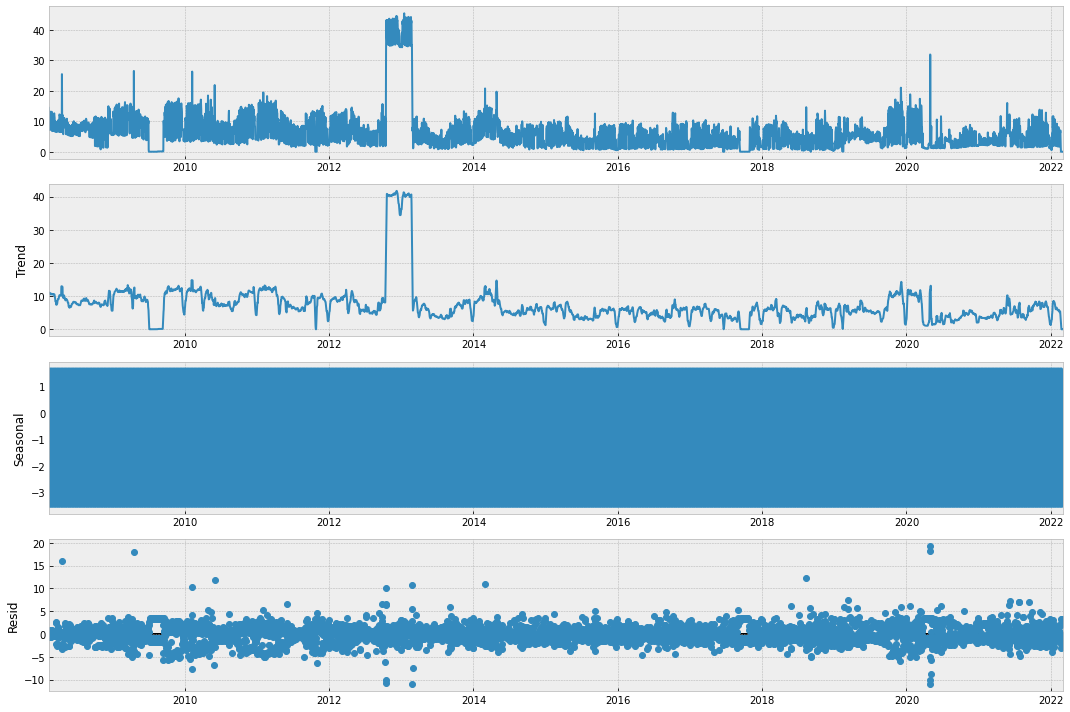

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(daily_data, model='additive')

fig = decomposition.plot()

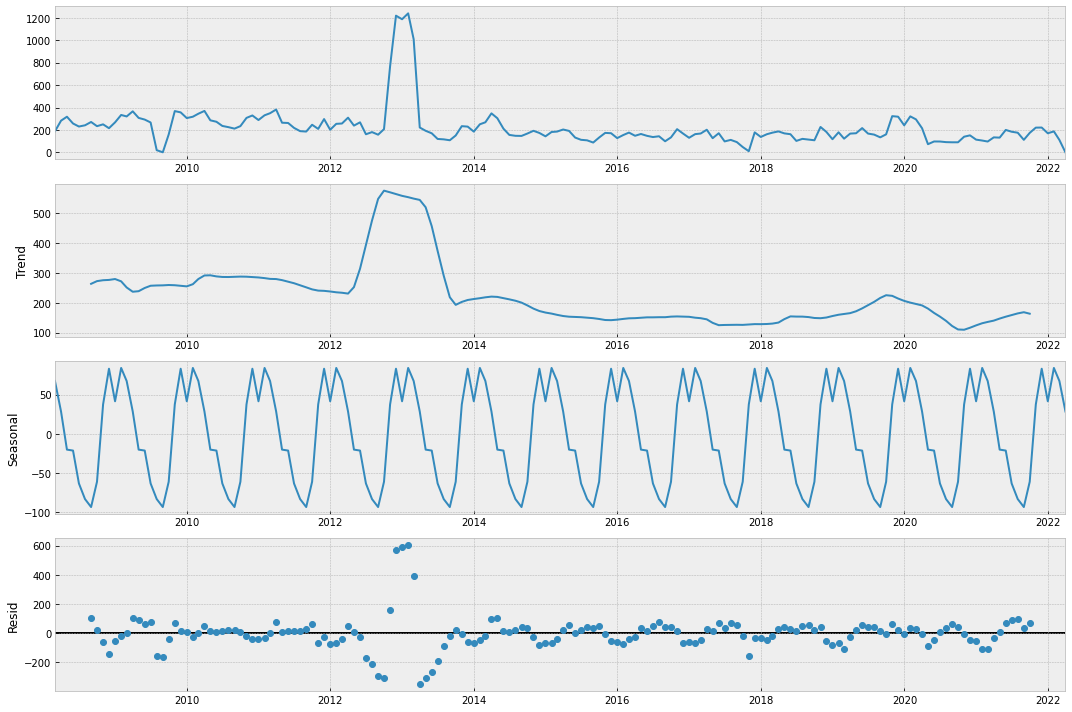

In [124]:
monthly_data = data.resample(rule='M').sum()
decomposition = seasonal_decompose(monthly_data, model='additive')

fig = decomposition.plot()

In [125]:
#Create new dataset for heatmap
heatmap_data = daily_data.copy()

#First we need to add weekdays as a column
heatmap_data['Weekday_Name'] = daily_data.index.day_name()

#Next add the year as column and group the data up to annual day of the week level
heatmap_data['Year'] = heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Weekday_Name']).sum()

#Reset indices
heatmap_data = heatmap_data.reset_index()

# Drop 2022 as not a full year
heatmap_data = heatmap_data[heatmap_data['Year'] != 2022]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Weekday_Name', values='value')

# Reorder columns
heatmap_data = heatmap_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

heatmap_data.head(100)

Weekday_Name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Year,,,,,,,
2008,444.463,452.137,461.220,469.413,432.739,245.017,256.427
2009,516.501,536.191,545.445,555.811,482.592,233.826,233.061
2010,604.234,618.556,611.634,613.702,558.174,206.167,216.275
2011,538.804,578.278,559.706,579.024,511.281,197.543,177.885
2012,834.640,834.884,827.988,847.868,805.470,532.969,530.622
2013,621.036,655.788,632.895,667.775,615.589,397.853,391.097
2014,425.987,442.814,427.372,432.193,390.100,206.239,191.696
2015,319.539,337.637,320.674,336.481,296.658,112.226,89.043
2016,313.459,346.994,325.128,350.797,303.849,100.278,75.334


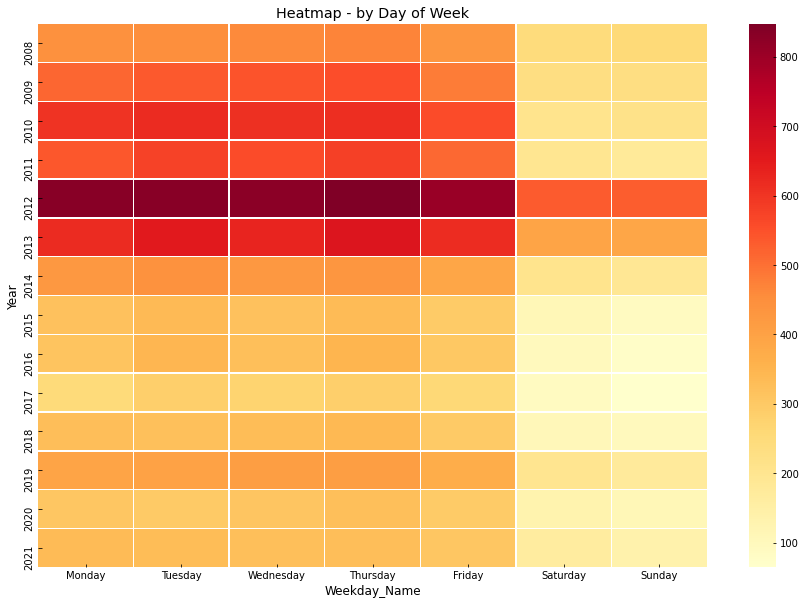

In [126]:
# Visualise electricity load via Heatmap
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True).set_title('Heatmap - by Day of Week')
plt.savefig(building+'_Water_Daily_Heatmap.PNG')

In [134]:
# Create new dataset for heatmap
heatmap_data = data.copy()

# First we need to add weekdays as a column
heatmap_data['Hour'] = data.index.hour

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Hour']).sum()

# Reset index 
heatmap_data = heatmap_data.reset_index()

# We drop off 2018 because it's not a full year
heatmap_data = heatmap_data[heatmap_data['Year'] != 2022]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Hour', values='value')

heatmap_data.head(100)

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Year,,,,,,,,,,,,,,,,,,,,,
2010,31.498,32.267,30.975,33.729,36.978,105.884,132.936,143.061,193.176,236.563,...,340.113,323.365,264.574,196.532,144.934,111.361,77.048,52.934,38.789,33.198
2011,37.674,37.236,37.053,38.571,43.633,130.426,162.539,188.931,263.826,330.584,...,480.204,447.540,370.612,291.120,225.219,169.993,117.084,70.285,46.691,40.490
2012,142.408,154.994,159.997,159.025,122.892,215.649,242.159,255.070,329.045,390.802,...,493.714,450.984,378.579,287.325,218.054,170.301,129.619,92.838,78.689,116.595
2013,278.613,280.735,289.266,288.165,212.107,277.808,334.964,362.516,435.144,508.025,...,573.031,527.587,435.941,335.269,249.552,195.078,143.075,111.708,104.980,220.239
2014,180.442,239.693,257.806,261.138,242.669,225.819,282.737,277.089,345.587,418.390,...,527.259,502.006,430.933,339.632,256.739,203.822,148.687,100.031,70.705,96.273
2015,211.860,242.643,250.128,252.020,253.145,288.943,341.296,346.798,404.722,465.591,...,530.066,500.472,416.049,332.465,258.989,208.102,165.812,129.241,117.804,132.654
2016,121.672,132.806,129.878,131.945,142.068,227.239,304.174,326.535,378.988,440.505,...,527.173,501.424,420.942,322.419,247.267,197.025,155.186,119.890,103.972,106.934
2017,100.868,113.337,117.999,117.849,121.472,174.983,259.416,271.052,337.386,401.923,...,488.436,464.829,395.316,313.338,242.627,178.145,142.651,110.040,92.888,90.454
2018,143.839,166.102,163.358,162.430,170.479,225.038,313.466,318.549,361.768,416.672,...,534.573,515.933,460.315,371.400,287.030,231.777,187.385,157.984,141.751,136.599


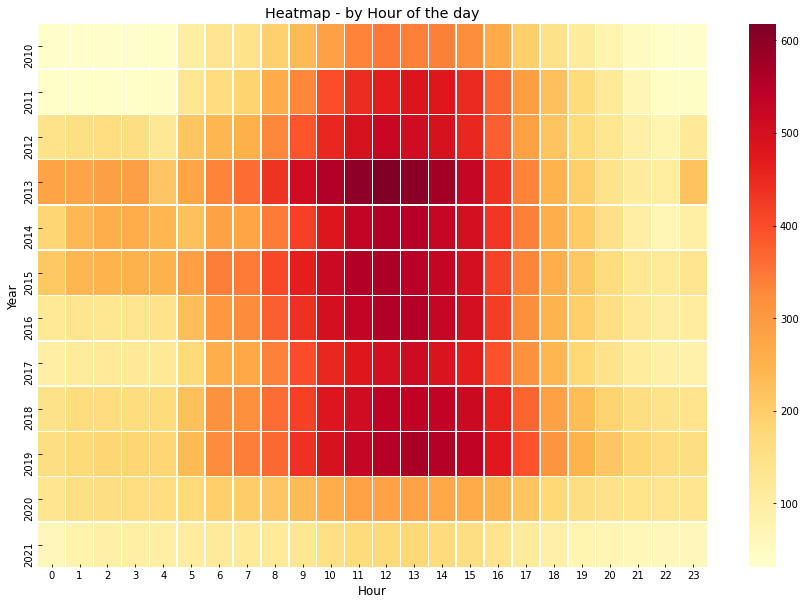

In [135]:
# Visualise electricity load via Heatmap
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True).set_title('Heatmap - by Hour of the day')
plt.savefig(building+'_Water_Hourly_Heatmap.PNG')

In [129]:
# Create new dataset for heatmap
heatmap_data = daily_data.copy()

# First we need to add weekdays as a column
heatmap_data['Month'] = daily_data.index.month_name()

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Month']).sum()

# Reset index
heatmap_data = heatmap_data.reset_index()

# We drop off 2022 because it's not a full year
heatmap_data = heatmap_data[heatmap_data['Year'] != 2022]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Month', values='value')

# Reorder columns
heatmap_data = heatmap_data[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]

heatmap_data.head(10)

Month,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2008,NaN,188.110,283.276,318.416,257.955,230.955,241.914,271.620,234.158,250.554,216.130,268.328
2009,334.080,320.898,366.516,307.899,292.944,267.149,20.153,1.399,160.162,368.703,357.141,306.383
2010,318.452,345.206,370.079,286.360,273.499,236.395,225.453,212.325,234.607,307.875,329.612,288.879
2011,331.083,349.785,382.586,265.031,262.665,218.926,189.848,186.137,246.790,209.955,297.419,202.296
2012,254.965,257.897,310.035,239.227,268.506,162.155,181.380,158.295,207.699,767.608,1219.208,1187.466
2013,1239.846,1009.277,222.308,193.005,170.707,120.260,116.661,108.602,151.109,234.312,230.291,185.655
2014,250.969,268.909,348.330,305.074,212.086,156.303,148.336,147.342,168.667,192.936,173.750,143.699
2015,182.255,185.989,204.415,191.985,132.632,112.651,107.918,88.240,132.820,174.257,171.405,127.691
2016,155.206,177.044,148.648,164.584,148.018,137.215,144.248,99.623,134.395,207.502,168.723,130.633


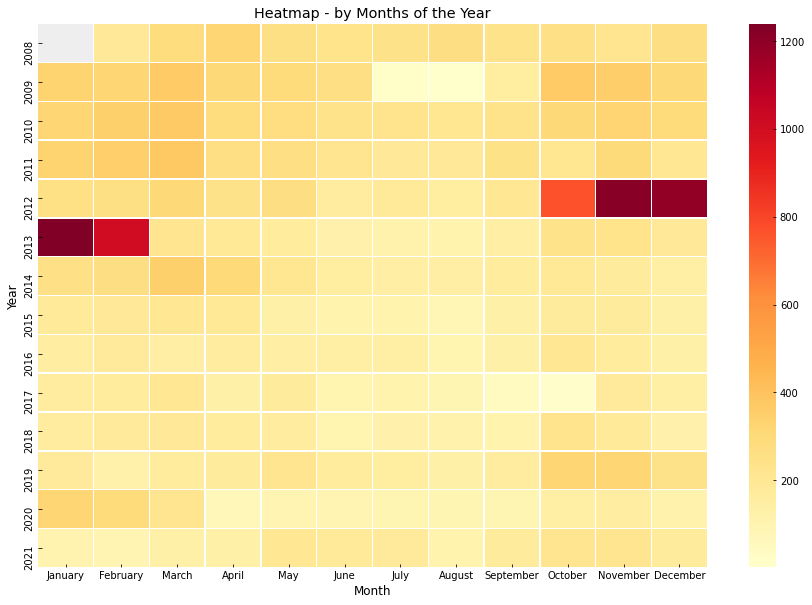

In [130]:
# Visualise electricity load via Heatmap
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True).set_title('Heatmap - by Months of the Year')
plt.savefig(building+'_Water_Monthly_Heatmap.PNG')